# Regression with model *y = b + w1*x + w2*(x)^2*
Try to find a function that can predict the temperature by using salnty.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sympy import diff, symbols, lambdify
from sympy.abc import x, y

In [3]:
data = pd.read_csv('/Users/yuwenchen/Desktop/2190_3685_bundle_archive/bottle.csv')
data = pd.DataFrame(data)

/Users/yuwenchen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
Simply drop the null value.

In [5]:
# predict the water temperature based on salinity
att = data[['T_degC', 'Salnty']]

# remove NAN values
att = att.dropna()

# reset the index
att = att.reset_index(drop=True)

# Normalization
normalize the data between 0 - 1

In [6]:
# I only derive 1000 sample as training data
batchSize = 1000

In [7]:
train_x = att['Salnty'].loc[:batchSize]
train_y = att['T_degC'].loc[:batchSize]

In [8]:
def normalization (x):
    return (x - min(x)) / (max(x) - min(x))

In [9]:
x_data = normalization(train_x).tolist()
y_data = normalization(train_y).tolist()

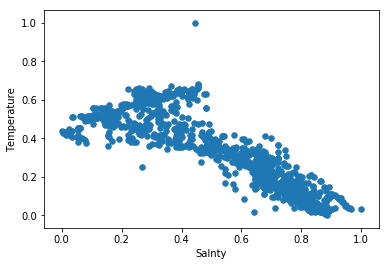

In [10]:
# plot the data after normalizing into 0 - 1
plt.scatter(x_data, y_data, s = 30)
plt.xlabel('Salnty')
plt.ylabel('Temperature')
plt.show()

# Traning Phase
Use Gradient Descent to train the model *y = b + w1*x + w2*(x)^2*.
<br>The intial function are set to be *y = -0.6x + 0.0x^2 + 0.6*.
<br>Adagrad for learning rate.

In [11]:
b = ori_b = 0.6 # initial b
w1 = ori_w1 = -0.6 # initial w2
w2 = ori_w2 = 0.0 # initial w2

In [12]:
lr = 0.001 # learning rate
iteration = 100000

# store initial vlaues for plotting
b_history = []
w1_history = []
w2_history = []
loss_history = []

# set the learning rate be different
lr_b = 0
lr_w1 = 0
lr_w2 = 0


# The following five paramters(x, y, w1_df, w2_df, b_df) are just for caculating the differentiation of loss function
x, y, w1_df, w2_df, b_df = symbols('x, y, w1_df, w2_df, b_df')
# y_data = b + w1*data_x + w2*(data_x^2) 
lossf = (y - (b_df + w1_df*x + w2_df*(x**2)))**2
diff_b = lambdify([x, y, w1_df, w2_df, b_df], diff(lossf, b_df))
diff_w1 = lambdify([x, y, w1_df, w2_df, b_df], diff(lossf, w1_df))
diff_w2 = lambdify([x, y, w1_df, w2_df, b_df], diff(lossf, w2_df))

# interation start, use gradient descent to find the best b and w that can let the output be the least 
for i in range(iteration):
    b_grad = 0.0
    w1_grad = 0.0
    w2_grad = 0.0
    loss = 0.0

    for n in range(len(x_data)):
        
        # compute the loss
        loss = loss + (y_data[n] - (b + w1*x_data[n] + w2*(x_data[n]**2)))**2
        
        # compute ∂L/∂b 
        b_grad = b_grad + diff_b(x_data[n], y_data[n], w1, w2, b)
        
        # compute ∂L/∂w1
        w1_grad = w1_grad + diff_w1(x_data[n], y_data[n], w1, w2, b)
        
        # compute ∂L/∂w2
        w2_grad = w2_grad + diff_w2(x_data[n], y_data[n], w1, w2, b)
    
    # use Adagrad for leanring rate
    lr_b = lr_b + b_grad ** 2
    lr_w1 = lr_w1 + w1_grad ** 2
    lr_w2 = lr_w2 + w2_grad ** 2

    # update b, w1 and w2
    b = b - lr/np.sqrt(lr_b) * b_grad
    w1 = w1 - lr/np.sqrt(lr_w1) * w1_grad
    w2 = w2 - lr/np.sqrt(lr_w2) * w2_grad


    # print(b, w1, w2, loss)
    if i % 1000 == 0:
        print("Step: {}. Loss: {}".format(i, loss))
    
    # for plotting
    loss_history.append(loss)
    b_history.append(b)
    w1_history.append(w1)
    w2_history.append(w2)

Step: 0. Loss: 12.287366955590775
Step: 1000. Loss: 9.884196145713473
Step: 2000. Loss: 9.636658815760578
Step: 3000. Loss: 9.514908244518518
Step: 4000. Loss: 9.43757435887795
Step: 5000. Loss: 9.379419732551805
Step: 6000. Loss: 9.330626400893953
Step: 7000. Loss: 9.286971567887877
Step: 8000. Loss: 9.246516366025553
Step: 9000. Loss: 9.20831483455817
Step: 10000. Loss: 9.171871448517283
Step: 11000. Loss: 9.136902809736704
Step: 12000. Loss: 9.10322961710289
Step: 13000. Loss: 9.070726361508463
Step: 14000. Loss: 9.039297245609962
Step: 15000. Loss: 9.00886427462569
Step: 16000. Loss: 8.979361114989626
Step: 17000. Loss: 8.95072975026927
Step: 18000. Loss: 8.92291853230763
Step: 19000. Loss: 8.895880953826586
Step: 20000. Loss: 8.869574811968002
Step: 21000. Loss: 8.843961596478767
Step: 22000. Loss: 8.819006016123362
Step: 23000. Loss: 8.794675616503849
Step: 24000. Loss: 8.77094046255975
Step: 25000. Loss: 8.74777286952579
Step: 26000. Loss: 8.725147171829805
Step: 27000. Loss: 8.

In [13]:
# following are the final w1, w2 and b
w1, w2, b

(-0.20427382011282563, -0.46344969218881416, 0.5956609147520185)

# Visualize the Loss
visualize the loss over 100000 iterations.

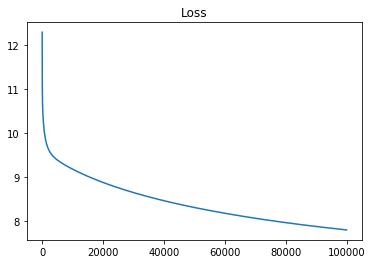

In [14]:
fig = plt.figure()
plt.title("Loss")
plt.plot(range(0,iteration), loss_history[0:iteration])    
plt.show()

# Plot the Normalized Result
Green line is the intial function.
<br> Red line is the learned function that has the minimum loss.

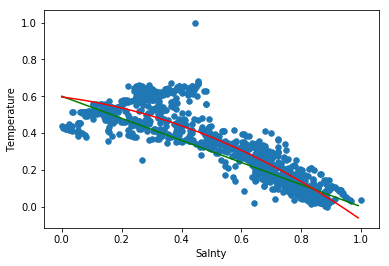

In [15]:
plt.scatter(x_data, y_data, s = 30)
plt.xlabel('Salnty')
plt.ylabel('Temperature')

x_nm = np.arange(min(x_data), max(x_data), 0.01)

# initial function (before training)
y_init = ori_w1*x_nm + ori_w2*(x_nm**2) + ori_b
plt.plot(x_nm, y_init, color = "green")

# predicted fucntion 
y_result = w1*x_nm + w2*(x_nm**2) + b
plt.plot(x_nm, y_result, color = 'red')

plt.show()

# Denomalize *w1*, *w2* and *b*

In [16]:
def denomalization(x, y, w1, w2, b):
    A = max(y) - min(y)
    B = max(x) - min(x)
    
    den_b = A*b + min(y) + (A*w2*(min(x)**2)/B**2) - (A*w1*min(x))/B
    den_w1 = A*((w1/B) - ((w2*2*min(x))/B**2))
    den_w2 = A*w2/B**2
    return den_w1, den_w2, den_b

In [17]:
x_output = train_x.tolist()
y_output = train_y.tolist()

res_w1, res_w2, res_b = denomalization(x_output, y_output, w1, w2, b)

# plot the denomalized w1, w2 and b
# this is for the result part
res_w1, res_w2, res_b

(124.14198427838681, -1.928579495482329, -1984.4674428377627)

# Plot the result
Green line is the intial function.
<br>Red line is the learned function that has the minimum loss.

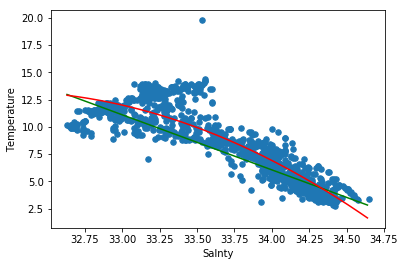

In [18]:
plt.scatter(x_output, y_output, s = 30)
plt.xlabel('Salnty')
plt.ylabel('Temperature')

x_dnm = np.arange(min(x_output), max(x_output), 0.01)


# intial function
w1_ori_dnm, w2_ori_dnm, b_ori_dnm = denomalization(x_output, y_output, ori_w1, ori_w2, ori_b)
y_ini_dnm = w1_ori_dnm*x_dnm + w2_ori_dnm*(x_dnm**2) + b_ori_dnm
plt.plot(x_dnm, y_ini_dnm, color = "green")

# predicted fucntion 
y_dnm_result = res_w1*x_dnm + res_w2*(x_dnm)**2 + res_b
plt.plot(x_dnm, y_dnm_result, color = 'red')

plt.show()

# Testing Phase
Derive another differnt 100 samples from CalCOFI.
<br> Use R2 score to examine the goodness of this fucntion

In [62]:
testingSize = 100

In [63]:
test_x = att['Salnty'].loc[batchSize:batchSize + testingSize]

# predicted output for 100 samples
temp = res_w1*test_x + res_w2*(test_x)**2 + res_b
pre_y = temp.tolist()

# actual output
test_y = att['T_degC'].loc[batchSize:batchSize + testingSize].tolist()

test_x = test_x.tolist()

In [64]:
SSE = 0.0
SST = 0.0
y_bar = np.mean(pre_y)

for i in range (testingSize):
    SSE = SSE + (pre_y[i] - test_y[i])**2
    SST = SST + (pre_y[i] - y_bar)**2
    
R2 = 1 - (SSE/SST)

print("R2 score for this function is:", R2)

R2 score for this function is: 0.6451374351605255
